In [5]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import SparsePCA, PCA
from sklearn.base import clone
import os
import pandas as pd
import tqdm
import glob
import random
import itertools
# Import all models
from sklearn.ensemble import IsolationForest
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
# from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.lscp import LSCP
import shap
from subprocess import check_output
%matplotlib inline

# data_loc = '/media/gabriel/storage/dipet/csv_concat'
# data_loc = '/media/gabriel/storage/dipet/csv'
data_loc = '/home/gabriel/research/dipet/csv'
reg_file = "*-state-0.csv"

# print(check_output(["ls", "../media/gabriel/storage/dipet/csv"]).decode("utf8"))

In [32]:
def load_filter_low_variance(data_loc,
                             reg_file,
                             low_varaince=True):
    """
    :param data_loc: directory where files are located
    :param network_file: name of the csv to be loaded
    :return:
    """
    print("Data location: ")
    print(data_loc)
    print("Work dir")
    print(os.getcwd())
    print("Checking files in data location ...")

    # Load files for a particular node based on reg_file
    files = glob.glob(os.path.join(data_loc, reg_file))
    list_df = []
    for f in tqdm.tqdm(files):
        # print(f)
        df = pd.read_csv(f)
        list_df.append(df)

    # Get Column file
    column_size = []
    for d in list_df:
        # print(d.shape)
        column_size.append(d.shape[-1])

    if low_varaince:
        from collections import Counter
        items = Counter(column_size).keys()
        print("Unique column size: {}".format(items))
        print(f"Columns found: {list_df[0].columns}")

        df_work = list_df[0]
        print("Checking low variance columns ...")
        print("Starting Clean dataset")
        uniques = df_work.apply(lambda x: x.nunique())
        rm_columns = []
        for uindex, uvalue in uniques.iteritems():
            if uvalue == 1:
                rm_columns.append(uindex)
        print("First pass columns to be removed")
        print(rm_columns)

        # Find common low variance elements in list of low variance columns
        list_low_varaince = []
        for df in list_df:
        # Check for monotonous columns and remove them
            print("Checking low variance columns ...")
            print("Starting Clean dataset")
            uniques = df.apply(lambda x: x.nunique())
            rm_columns = []
            for uindex, uvalue in uniques.iteritems():
                if uvalue == 1:
                    rm_columns.append(uindex)
            print(rm_columns)
            list_low_varaince.append(rm_columns)

        common_low_variance = list(set.intersection(*map(set, list_low_varaince)))
        print("Common low variance columns:")
        print(common_low_variance)

        # Remove common low variance columns
        for df in list_df:
            df.drop(common_low_variance, inplace=True, axis=1)

    # Check datatypes of columns
    # for df in list_df:
    #     print(df.dtypes)

    # Concat all dataframes
    df_concat = pd.concat(list_df, ignore_index=True)
    print(f"Concatenated all data, new shape is {df_concat.shape} and columns are:")
    print(df_concat.shape)

    return df_concat

def filter_columns_wildcard(df_work, wild_card):
    """
    :param wild_card: str wildcard of columns to be filtered
    :return:
    """
    filter_col_wildcard = wild_card
    filtr_list = []
    mask = df_work.columns.str.contains(filter_col_wildcard)
    filtr_list.extend(list(df_work.loc[:,mask].columns.values))
    print("Columns to be filtered:")
    print(filtr_list)
    df_concat_filtered = df_work[filtr_list]

    print(f"Filtered shape: {df_concat_filtered.shape}")
    print("Columns of filtered data:")
    print(df_concat_filtered.columns)
    return df_concat_filtered

def filter_nan_col(df_concat_filtered,
                   drop_threashold=0.4,
                   verbose=0):
    """
    :param drop_threashold: threashold for dropping columns based on NaN values
    :return:
    """
    # Count nan values per column and set drop threashold
    drop_list_th = []
    for c in df_concat_filtered.columns.values:
        percentage_nan = 100*df_concat_filtered[c].isna().sum()/len(df_concat_filtered)
        if verbose:
            print(f"Length of column {c} is {len(df_concat_filtered)}")
            print(f"Of which {df_concat_filtered[c].isna().sum()} are nan")
            print(f"Percentage of nan in {c} is {percentage_nan}")
        if percentage_nan > drop_threashold:
            # print(f"Percentage of nan in {c} is {percentage_nan}")
            drop_list_th.append(c)
    print(f"Colsumns before nan drop: {df_concat_filtered.shape[-1]}")
    print(f"Columns to be droped {len(drop_list_th)}")
    # print(drop_list_th)
    # print(df_concat_filtered.columns)
    df_concat_filtered.drop(drop_list_th, axis=1, inplace=True)

def decision_boundary(clf,
                      data,
                      anomaly_label = -1,
                      model_name = "Not defined"):
    """
    :param clf: model to be refitted with 2 features (PCA)
    :param data: dataset after PCA
    :param anomaly_label: label for anomaly instances (differs from method to method)
    :param model_name: name of the model to be displayed
    :return:
    """

    # fit model
    clf.set_params(max_features=data.shape[-1]) # becouse we have only two features we must override previous setting
    clf.fit(data)
    y_pred_outliers = clf.predict(data)

    # get anomaly index
    anomaly_index_rf = np.where(y_pred_outliers==anomaly_label)
    # Get anomalies based on index
    ano_rf = data[anomaly_index_rf]
    # plot the line, the samples, and the nearest vectors to the plane
    xx, yy = np.meshgrid(np.linspace(-80, 80, 80), np.linspace(-80, 80, 80))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.title(model_name)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
    b1 = plt.scatter(data[:, 0], data[:, 1], c='white',
                 s=20, edgecolor='k')
    c = plt.scatter(ano_rf[:, 0], ano_rf[:, 1], c='red',
                s=20, edgecolor='k')
    plt.axis('tight')
    plt.xlim((-50, 80))
    plt.ylim((-5, 80))
    plt.legend([b1, c],
           ["normal",
            "anomaly",],
           loc="upper left")
    plt.show()

def plot_on_features(data, pred, anomay_label=-1):
    """
    :param data: dataset used for training or prediction
    :param pred: model prediction
    :param anomay_label: label for anomaly instances (differs from method to method)
    :return:
    """
    col_names_plt = list(data.columns.values)
    data['anomaly'] = pred
    for feature in col_names_plt:
        if feature == 'epoch' or feature == 'anomaly':
            pass
        else:
            # fig, ax = plt.subplots(figsize=(15,10))
            a = data[data['anomaly'] == anomay_label] #anomaly
            _ = plt.figure(figsize=(18,6))
            _ = plt.plot(data[feature], color='blue', label='Normal')
            _ = plt.plot(a[feature], linestyle='none', marker='X', color='red', markersize=4, label='Anomaly')
            _ = plt.xlabel('Date and Time')
            _ = plt.ylabel(f'{feature}')
            _ = plt.title(f'{feature} Anomalies')
            _ = plt.legend(loc='best')
            plt.show();

def plot_feature_sep(data, pred, anomaly_label=-1, normal_label=1):
    """
    :param data: dataset used for training or prediction
    :param pred: model prediction
    :param anomaly_label: label for anomaly instances (differs from method to method)
    :param normal_label:
    :return:
    """
    col_names_plt = list(data.columns.values)
    data['anomaly'] = pred
    for feature in col_names_plt:
        if feature == 'epoch' or feature == 'anomaly' or feature == 'id':
            pass
        else:
            normal_event = data.loc[data['anomaly'] == normal_label, feature]
            anomay_event = data.loc[data['anomaly'] == anomaly_label, feature]

            plt.figure(figsize=(10, 6))
            plt.hist(normal_event, bins = 50, alpha=0.5, density=True,label='{} normal'.format(feature))
            plt.hist(anomay_event, bins = 50, alpha=0.5, density=True, label='{} anomaly'.format(feature))
            plt.legend(loc='upper right')
            plt.xlabel(feature)
            plt.ylabel('Count')
            plt.show();

def add_clusters_labels(df_work, labels):
    """
    :param df_work: raw dataset (usually after PCA)
    :param labels: series representing labels
    :return: labeled dataframe, index of anomalies
    """
    df_work_labels = df_work
    df_work_labels['labels'] = labels
    print(f"Unique labels for cluster are: {np.unique(labels)}")
    list_cluster_index = []
    for l in np.unique(labels):
        # list_cluster_index.append(np.where(labels==l))
        if l == -1:
            print(f"Number of anomalies {df_work_labels.index[df_work_labels['labels'] == l].shape[0]}")
        list_cluster_index.append(df_work_labels.index[df_work_labels['labels'] == l])
    return df_work_labels, list_cluster_index

def split_on_index(df_work_labeled, list_cluster_index, ):
    """
    :param list_cluster_index: indexes of anomalies
    :param df_work_labeled: labeled dataframe
    :return: list of dataframes split by cluster (one df for each cluster)
    """
    print(list_cluster_index)
    # Split anomalies based on index
    list_cluster_df = []
    for al in list_cluster_index:
        print(f"Size of cluster: {al.shape[0]}")
        list_cluster_df.append(df_work_labeled.loc[al])
    return list_cluster_df

def plot3d(list_cluster_df_3):
    color_marker = itertools.cycle(('r', 'b', 'g', 'c', 'm', 'y'))
    marker = itertools.cycle((',', '+', '.', 'o', '*'))
    fig = plt.figure(figsize=(15,15))

    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlabel("x_composite_3")
    # Plot the compressed data points

    for i, df in enumerate(list_cluster_df_3):
        if i == 0:
            ax.scatter(df_work_pca_3d.to_numpy()[:, 0], df_work_pca_3d.to_numpy()[:, 1], zs=df_work_pca_3d.to_numpy()[:, 2], s=4, lw=1, label="noise",c="blue")
            print(f"Noise has shape {df.shape}")
        else:
            print(f"Cluster {i} has shape {df.shape}")
            ax.scatter(df.to_numpy()[:,0],df.to_numpy()[:,1], df.to_numpy()[:,2],
                   lw=2, s=20, marker=next(marker), c=next(color_marker), label=f"cluster_{i}")

        # ax.scatter(df_work_pca_3d[df,0],df_work_pca_3d[df,1], df_work_pca_3d[df,2],
        #            lw=2, s=60, marker=next(marker), c=next(color_marker), label=f"cluster_{i}")
    ax.legend()
    plt.show()

def plot_2d(list_cluster_df):
    color_marker = itertools.cycle(('r', 'b', 'g', 'c', 'm', 'y'))
    marker = itertools.cycle((',', '+', '.', 'o', '*'))

    # hexadecimal_alphabets = '0123456789ABCDEF'
    # color = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in range(6)]) for i in range(n_clusters_+n_noise_)]

    fig = plt.figure(figsize=(15,15))
    plt.scatter(df_work_pca.to_numpy()[:,0], df_work_pca.to_numpy()[:,1])
    for i, df in enumerate(list_cluster_df):
        if i == 0: # todo check if anomaly is always first
            print(f"Noise has shape {df.shape}")
            plt.scatter(df.to_numpy()[:,0], df.to_numpy()[:,1], color=next(color_marker), marker=next(marker), label="noise")
        else:
            print(f"Cluster {i} has shape {df.shape}")
            plt.scatter(df.to_numpy()[:,0], df.to_numpy()[:,1], color=next(color_marker), marker=next(marker), label=f"cluster_{i}")
    # plt.scatter(labels[:,0], labels[:,1], color='r', marker='x')
    plt.title("DBSCAN plot with a total of {} anomalies".format(list(pred).count(-1)))
    plt.legend()
    plt.grid()
    plt.show()

In [33]:
df_work = load_filter_low_variance(data_loc=data_loc,reg_file=reg_file, low_varaince=True)

 25%|██▌       | 3/12 [00:00<00:00, 28.73it/s]

Data location: 
/home/gabriel/research/dipet/csv
Work dir
/home/gabriel/research/dipet
Checking files in data location ...


100%|██████████| 12/12 [00:00<00:00, 26.36it/s]


Unique column size: dict_keys([47])
Columns found: Index(['datetime', 'uid', 'name', 'id', 'processes', 'loadavg-m1',
       'softirq.rate', 'iowait.rate', 'intr.rate', 'system.rate', 'btime.rate',
       'idle.rate', 'user.rate', 'irq.rate', 'ctxt.rate', 'nice.rate',
       'nr_slab_unreclaimable', 'workingset_refault', 'nr_anon_pages',
       'active_file', 'cached', 'apps', 'mapped', 'active_anon', 'free',
       'swap_cache', 'page_tables', 'inactive', 'shmem', 'committed', 'active',
       'vmalloc_used', 'slab_cache', 'buffers', 'swap', 'eth.txe.rate',
       'eth.rxe.rate', 'eth.txb.rate', 'eth.rxb.rate', 'eth.txp.rate',
       'eth.rxp.rate', 'wifi.txe.rate', 'wifi.rxe.rate', 'wifi.txb.rate',
       'wifi.rxb.rate', 'wifi.txp.rate', 'wifi.rxp.rate'],
      dtype='object')
Checking low variance columns ...
Starting Clean dataset
First pass columns to be removed
['uid', 'iowait.rate', 'btime.rate', 'irq.rate', 'nice.rate', 'workingset_refault', 'swap_cache', 'swap', 'eth.txe.rate

In [34]:
wild_card = 'x'
df_work = filter_columns_wildcard(df_work=df_work,wild_card=wild_card)


Columns to be filtered:
['ctxt.rate', 'eth.txb.rate', 'eth.rxb.rate', 'eth.txp.rate', 'eth.rxp.rate', 'wifi.txb.rate', 'wifi.rxb.rate', 'wifi.txp.rate', 'wifi.rxp.rate']
Filtered shape: (93418, 9)
Columns of filtered data:
Index(['ctxt.rate', 'eth.txb.rate', 'eth.rxb.rate', 'eth.txp.rate',
       'eth.rxp.rate', 'wifi.txb.rate', 'wifi.rxb.rate', 'wifi.txp.rate',
       'wifi.rxp.rate'],
      dtype='object')


In [35]:
filter_nan_col(df_work, drop_threashold=0.4)

Colsumns before nan drop: 9
Columns to be droped 0


In [36]:
# Fill nan values
df_work.fillna(value=0, inplace=True)

In [37]:
# Scaling Data
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = StandardScaler()
# scaler = RobustScaler
scaler.fit(df_work)
scaled = scaler.transform(df_work)

# Scaled data back to df from np.array
df_work_filtered_scaled = pd.DataFrame(scaled, index=df_work.index, columns=df_work.columns)
df_work_filtered_scaled


,ctxt.rate,eth.txb.rate,eth.rxb.rate,eth.txp.rate,eth.rxp.rate,wifi.txb.rate,wifi.rxb.rate,wifi.txp.rate,wifi.rxp.rate
0,3.971539,-0.293410,-0.193448,-0.262359,-0.207234,-0.170177,-0.200343,-0.169363,-0.183261
1,4.641970,0.101708,0.117042,1.049199,0.464158,0.139803,0.246707,0.506945,1.221936
2,5.137924,-0.310354,-0.206647,-0.308812,-0.233002,-0.183695,-0.221741,-0.199381,-0.236620
3,4.498966,-0.310259,-0.206972,-0.306538,-0.232846,-0.183881,-0.221593,-0.197880,-0.233765
4,5.447557,-0.307978,-0.205770,-0.301261,-0.228761,-0.182839,-0.218960,-0.194904,-0.228193
...,...,...,...,...,...,...,...,...,...
93413,-0.220477,-0.277872,0.174627,-0.145399,0.093488,0.201299,-0.182177,0.134781,-0.063711
93414,-0.103577,0.434725,0.338774,0.372513,0.381899,0.279194,0.096545,0.283841,0.139865
93415,-0.347980,-0.266122,0.523818,-0.140208,0.399773,0.553648,-0.167094,0.449250,-0.055645
93416,-0.222471,-0.285321,0.452298,-0.184440,0.321781,0.480671,-0.191050,0.367450,-0.105154


First pass using anomaly detection methods:
Isolation Forest

In [38]:
contamination = 0.005
max_features = 8
# contamination = "auto"

clf_if = IsolationForest(n_estimators=10,
                         warm_start=False,
                         contamination=contamination,
                         max_features=max_features)
clf_clone = clone(clf_if)
clf_if.fit(df_work_filtered_scaled)
pred = clf_if.predict(df_work_filtered_scaled)
print("Anomalies in dataset of size {} found: {}".format(len(list(pred)),list(pred).count(-1)))


# Get anomaly index and the values based on said index
anomaly_index_df = np.where(pred==-1)

Anomalies in dataset of size 93418 found: 458


In [39]:
df_anomalies_only = df_work_filtered_scaled.iloc[anomaly_index_df]
df_anomalies_only.shape

(458, 9)

SHAP analysis

In [40]:
# Subsample the data for shap

df_work_filtered_scaled_sample = df_work_filtered_scaled.sample(frac = 0.05)
print(f"Sample size for shape analysis: {df_work_filtered_scaled_sample.shape}")

Sample size for shape analysis: (4671, 9)


In [41]:
explainer = shap.Explainer(clf_if.predict, df_work_filtered_scaled_sample)
shap_values = explainer(df_work_filtered_scaled_sample)

Exact explainer: 4672it [10:19,  7.42it/s]                          


In [44]:
shap.initjs()

In [45]:
sample_pred = clf_if.predict(df_work_filtered_scaled_sample)

sample_anomaly_index = np.where(sample_pred==-1)
sample_normal_index = np.where(sample_pred!=-1)
print("Index of found anomalies")
print(sample_anomaly_index)
print("Normal index")
print(sample_normal_index)
print("Sample columns")
print(df_work_filtered_scaled_sample.columns)

Index of found anomalies
(array([ 299,  428,  680,  711,  764,  894, 1213, 1445, 1636, 1647, 1804,
       2690, 2803, 2823, 2955, 3071, 3510, 3814, 3858, 4127, 4532, 4559,
       4623]),)
Normal index
(array([   0,    1,    2, ..., 4668, 4669, 4670]),)
Sample columns
Index(['ctxt.rate', 'eth.txb.rate', 'eth.rxb.rate', 'eth.txp.rate',
       'eth.rxp.rate', 'wifi.txb.rate', 'wifi.rxb.rate', 'wifi.txp.rate',
       'wifi.rxp.rate'],
      dtype='object')


In [46]:
shap.plots.force(shap_values[299])

In [47]:
shap.plots.force(shap_values[428])

In [48]:
shap.plots.force(shap_values[3510])

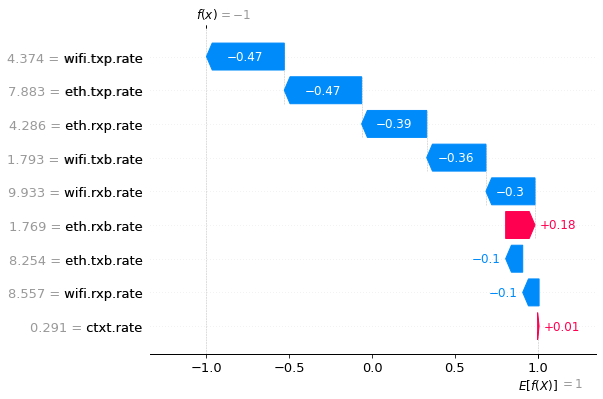

In [21]:
shap.plots.waterfall(shap_values[144])

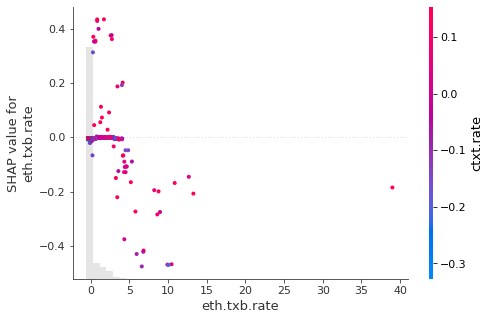

In [50]:
shap.plots.scatter(shap_values[:,'eth.txb.rate'], color=shap_values)


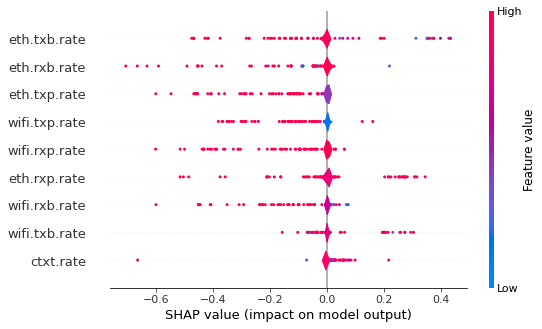

In [51]:
shap.summary_plot(shap_values, df_work_filtered_scaled_sample, plot_type="violin")

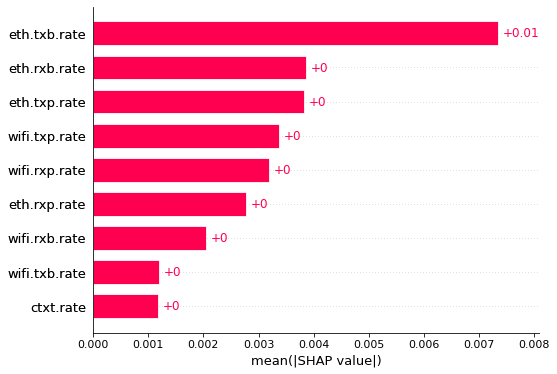

In [52]:
shap.plots.bar(shap_values,max_display=14)

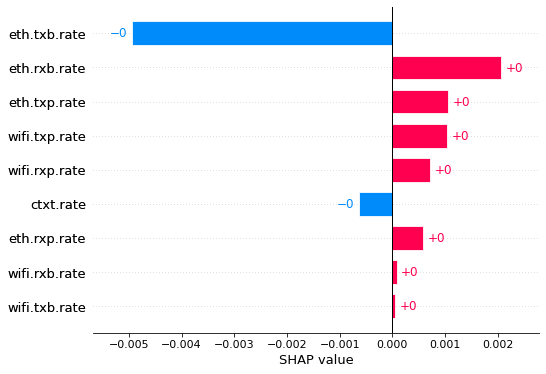

In [53]:
shap.plots.bar(shap_values[144],max_display=14)

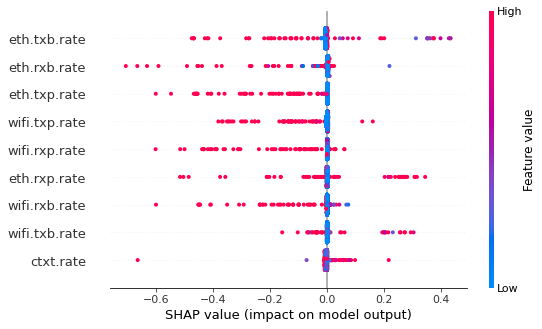

In [54]:
shap.plots.beeswarm(shap_values)

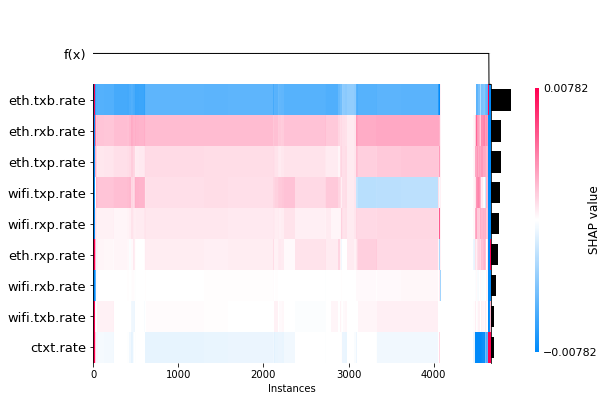

In [55]:
shap.plots.heatmap(shap_values)

Running clustering only on anomalous instances
DBScan

In [56]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Reduce dimensionality for DBSCAN otherwise everyting is noise
transformer = PCA(n_components=2)
transformer.fit(df_anomalies_only)
X_transformed = transformer.transform(df_anomalies_only)
print("Initial shape: {}".format(df_anomalies_only.shape))
print("PCA data shape: {}".format(X_transformed.shape))

df_work_pca = pd.DataFrame(X_transformed, index=df_anomalies_only.index) # pass only indeces as reduced colums from 9 to 2


dbscan = DBSCAN(eps=0.7, # try to play with this param for clustering (reduce noisy data
                min_samples=10,
                metric="euclidean",
                algorithm='auto',
                leaf_size=30,
                n_jobs=-1
                )

dbscan.fit(df_work_pca)

labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print(f'DBSCAN Estimated number of clusters: {n_clusters_}')
print(f'DBSCAN Estimated number of noise points: {n_noise_}')

Initial shape: (458, 9)
PCA data shape: (458, 2)
DBSCAN Estimated number of clusters: 2
DBSCAN Estimated number of noise points: 371


In [57]:
# Get clusters based on index

df_work_pca_labels, list_cluster_index = add_clusters_labels(df_work_pca, labels)


Unique labels for cluster are: [-1  0  1]
Number of anomalies 371


In [58]:
df_work_pca_labels

,0,1,labels
142,-9.971540,-12.854757,-1
146,-6.280331,-10.193448,-1
160,-11.052584,-9.546494,-1
184,-12.365140,-11.480494,-1
186,-5.636119,-11.382277,-1
...,...,...,...
93133,7.513067,23.169173,-1
93134,12.477513,28.946347,-1
93135,17.105929,34.701164,-1
93136,16.456767,34.247317,-1


In [59]:
# Split anomalies based on index
print(list_cluster_index)
list_cluster_df = split_on_index(df_work_pca, list_cluster_index)

[Int64Index([  142,   146,   160,   184,   186,   187,   245,   247,   248,
              249,
            ...
            91972, 91973, 91974, 91975, 91976, 93133, 93134, 93135, 93136,
            93137],
           dtype='int64', length=371), Int64Index([  246,   250,   271,   272,   274,  2054,  2056,  3387,  3855,
             3860,  5079, 13850, 14837, 14838, 16873, 19490, 21046, 25946,
            25958, 27822, 31533, 33430, 33431, 47748, 48786, 48791, 48795,
            48796, 48797, 49570, 49573, 49574, 49575, 49576, 49578, 49579,
            49580, 49581, 52114, 52127, 57404, 59948, 59949, 59950, 59951,
            59956, 59957, 74908, 85333, 87020, 88621, 89592, 91406, 91407,
            91514, 91569, 91970],
           dtype='int64'), Int64Index([ 4926,  7188,  8943, 12454, 12736, 13244, 13755, 15234, 17288,
            18145, 21003, 30549, 30793, 44478, 46049, 49206, 49480, 51844,
            72034, 72631, 73733, 76830, 77687, 81728, 83939, 85185, 85677,
            87462, 

Plotting clusters for 2D and 3D represenation of data

Noise has shape (371, 3)
Cluster 1 has shape (57, 3)
Cluster 2 has shape (30, 3)


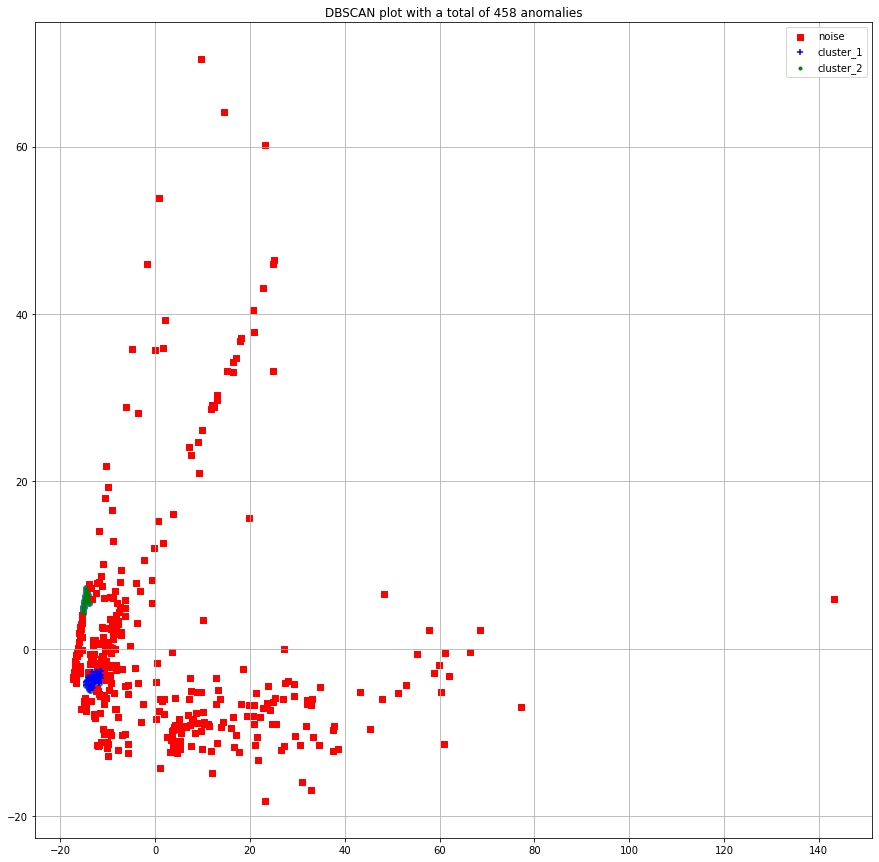

In [60]:
#Plot prediction on 2d

#Generate  Random color matplotlib
plot_2d(list_cluster_df)

In [61]:
transformer = PCA(n_components=3)
transformer.fit(df_anomalies_only)
X_transformed_3 = transformer.transform(df_anomalies_only)
print("Initial shape: {}".format(df_anomalies_only.shape))
print("PCA data shape: {}".format(X_transformed_3.shape))



df_work_pca_3d = pd.DataFrame(X_transformed_3, index=df_anomalies_only.index) # pass only indeces as reduced colums from 9 to 2
# add labels to df
df_work_pca_labels_3 = df_work_pca_3d
df_work_pca_labels_3['labels'] = labels
print(f"unique labels for clusters are: {np.unique(labels)}")
list_cluster_index_3 = []
for l in np.unique(labels):
    # list_cluster_index.append(np.where(labels==l))
    if l == -1:
        print(f"Number of anomalies {df_work_pca_labels_3.index[df_work_pca_labels_3['labels'] == l].shape[0]}")
    list_cluster_index_3.append(df_work_pca_labels_3.index[df_work_pca_labels_3['labels'] == l])
list_cluster_df_3 = []
for al in list_cluster_index_3:
    print(f"Size of cluster: {al.shape[0]}")
    list_cluster_df_3.append(df_work_pca_labels_3.loc[al])

Initial shape: (458, 9)
PCA data shape: (458, 3)
unique labels for clusters are: [-1  0  1]
Number of anomalies 371
Size of cluster: 371
Size of cluster: 57
Size of cluster: 30


Noise has shape (371, 4)
Cluster 1 has shape (57, 4)
Cluster 2 has shape (30, 4)


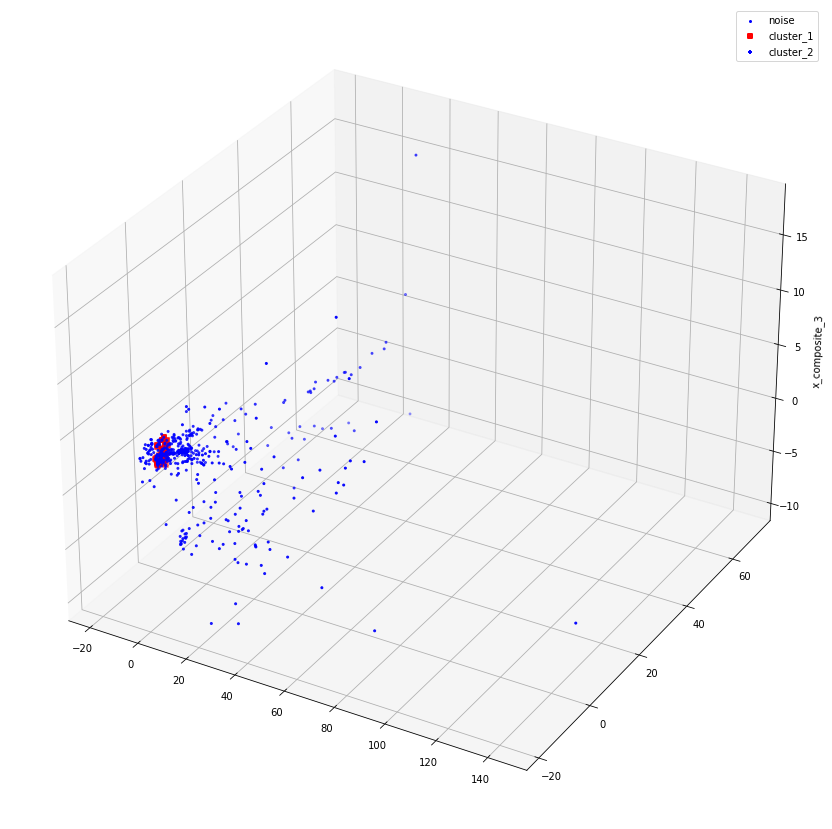

In [62]:
# Plot 3D anomaly map
plot3d(list_cluster_df_3)

Running clustering only on anomalous instances
Optics

In [63]:
from sklearn.cluster import OPTICS
opt_clust = OPTICS(min_samples=50,
                   eps=0.9,
                   xi=.05,
                   min_cluster_size=.05)
opt_clust.fit(df_work_pca)

labels_opt = opt_clust.labels_

# Number of clusters in labels, ignoring noise if present.
n_opt_clusters_ = len(set(labels_opt)) - (1 if -1 in labels_opt else 0)
n_opt_noise_ = list(labels_opt).count(-1)
print(f'Estimated number of clusters: {n_opt_clusters_}')
print(f'Estimated number of noise points: {n_opt_noise_}')

Estimated number of clusters: 2
Estimated number of noise points: 331


In [64]:
# Get clusters based on index

# add labels to df
df_work_pca_labels_opt, list_cluster_index_opt = add_clusters_labels(df_work_pca, labels_opt)


Unique labels for cluster are: [-1  0  1]
Number of anomalies 331


In [65]:
df_work_pca_labels_opt

,0,1,labels
142,-9.971540,-12.854757,-1
146,-6.280331,-10.193448,-1
160,-11.052584,-9.546494,-1
184,-12.365140,-11.480494,-1
186,-5.636119,-11.382277,-1
...,...,...,...
93133,7.513067,23.169173,-1
93134,12.477513,28.946347,-1
93135,17.105929,34.701164,-1
93136,16.456767,34.247317,-1


In [66]:
# Split anomalies based on index
list_cluster_opt_df = split_on_index(df_work_pca_labels_opt, list_cluster_index_opt, )


[Int64Index([  142,   146,   160,   184,   186,   187,   245,   246,   247,
              248,
            ...
            91971, 91972, 91973, 91974, 91976, 93133, 93134, 93135, 93136,
            93137],
           dtype='int64', length=331), Int64Index([ 2052,  2055,  2056,  3387,  3855,  3860,  5079, 13850, 14837,
            14838, 16873, 19490, 21046, 25123, 25946, 25958, 27822, 31533,
            33428, 33430, 33431, 47748, 48786, 48791, 48795, 48796, 48797,
            49570, 49573, 49574, 49575, 49576, 49578, 49579, 49580, 49581,
            52114, 52127, 52521, 57404, 59948, 59949, 59950, 59951, 59956,
            59957, 59959, 74908, 85333, 87020, 88621, 89592, 91406, 91407,
            91514, 91569, 91970],
           dtype='int64'), Int64Index([ 2549,  4163,  4223,  4754,  5099, 11723, 14829, 16589, 16591,
            16657, 16658, 21611, 21886, 22163, 22737, 23518, 24487, 25068,
            25102, 25811, 27800, 27801, 29293, 29622, 35146, 39864, 44505,
            47776, 

Noise has shape (331, 3)
Cluster 1 has shape (57, 3)
Cluster 2 has shape (70, 3)


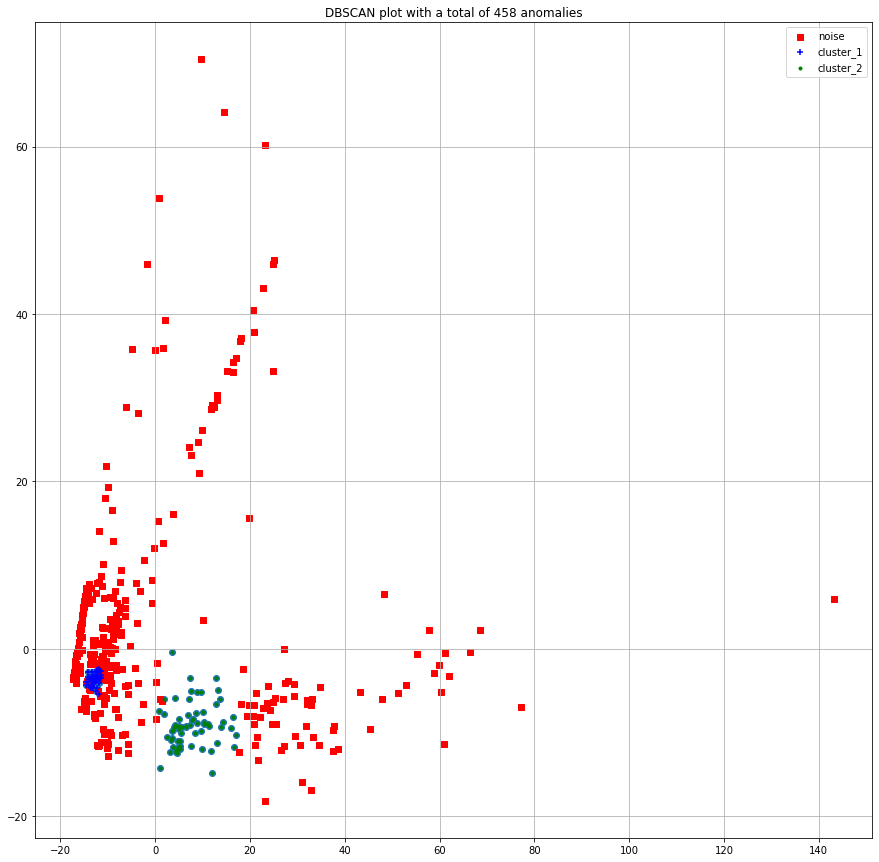

In [67]:
#Plot 2D
plot_2d(list_cluster_opt_df)

In [68]:
df_work_pca_3d

,0,1,2,labels
142,-9.971540,-12.854757,0.010199,-1
146,-6.280331,-10.193448,2.583806,-1
160,-11.052584,-9.546494,1.792806,-1
184,-12.365140,-11.480494,1.680082,-1
186,-5.636119,-11.382277,1.064231,-1
...,...,...,...,...
93133,7.513067,23.169173,0.981077,-1
93134,12.477513,28.946347,1.047195,-1
93135,17.105929,34.701164,1.604036,-1
93136,16.456767,34.247317,1.289794,-1


In [69]:
# add labels to df
df_work_pca_labels_opt_3 = df_work_pca_3d
df_work_pca_labels_opt_3['labels'] = labels_opt
print(f"unique labels for clusters are: {np.unique(labels_opt)}")
list_cluster_index_opt_3 = []
for l in np.unique(labels_opt):
    # list_cluster_index.append(np.where(labels==l))
    if l == -1:
        print(f"Number of anomalies {df_work_pca_labels_opt_3.index[df_work_pca_labels_opt_3['labels'] == l].shape[0]}")
    list_cluster_index_opt_3.append(df_work_pca_labels_opt_3.index[df_work_pca_labels_opt_3['labels'] == l])
list_cluster_df_opt_3 = []
for al in list_cluster_index_opt_3:
    print(f"Size of cluster: {al.shape[0]}")
    list_cluster_df_opt_3.append(df_work_pca_labels_opt_3.loc[al])

unique labels for clusters are: [-1  0  1]
Number of anomalies 331
Size of cluster: 331
Size of cluster: 57
Size of cluster: 70


Noise has shape (331, 4)
Cluster 1 has shape (57, 4)
Cluster 2 has shape (70, 4)


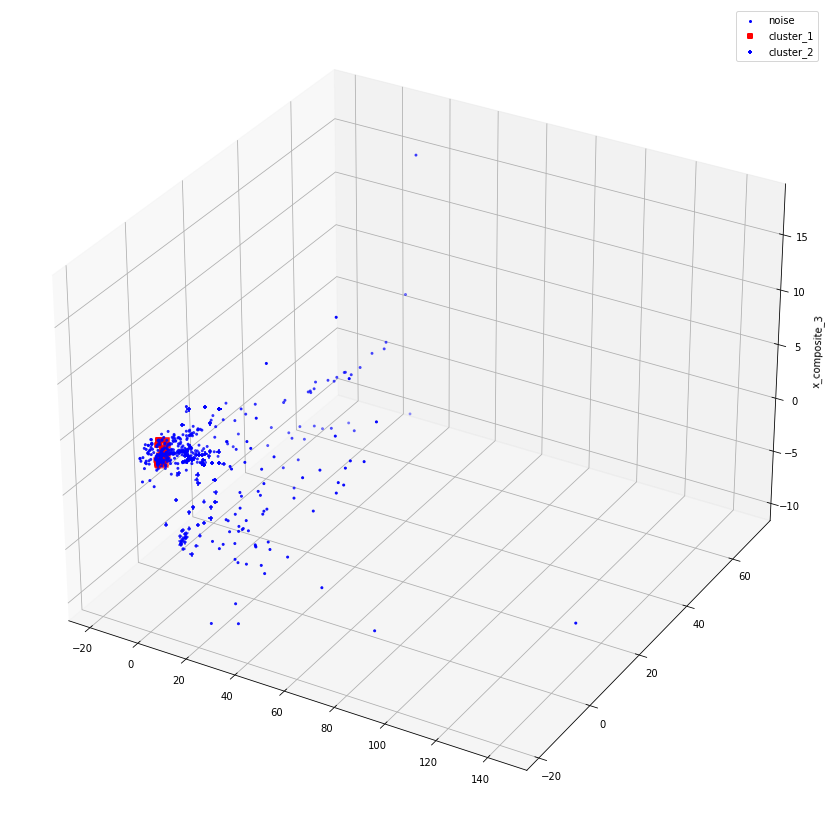

In [70]:
# Plot 3D anomaly map
plot3d(list_cluster_df_opt_3)

